In [264]:
import pandas as pd
import numpy as np
from math import pi
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import TimeSeriesSplit
import xgboost as xgb
import catboost as cb
import lightgbm as lgb
from scipy import stats

color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [245]:
train = pd.read_csv('/kaggle/input/rohlik-orders-forecasting-challenge/train.csv')
train_calendar = pd.read_csv('/kaggle/input/rohlik-orders-forecasting-challenge/train_calendar.csv')

test = pd.read_csv('/kaggle/input/rohlik-orders-forecasting-challenge/test.csv')
test_calendar = pd.read_csv('/kaggle/input/rohlik-orders-forecasting-challenge/test_calendar.csv')

In [246]:
def align_train_data(train_df, test_df, target_column=None):
    """
    Align columns of the training DataFrame to match the test DataFrame.
    
    Parameters:
    - train_df: DataFrame containing training data.
    - test_df: DataFrame containing test data.
    - target_column: Optional; target column to exclude from alignment.
    
    Returns:
    - Aligned training DataFrame with only columns present in the test DataFrame.
    """
    # Get columns to keep
    test_columns = test_df.columns.tolist()
    
    # Remove extra columns from the training DataFrame
    train_columns = [col for col in train_df.columns if col in test_columns]
    
    # Ensure the target column is included in the train DataFrame if it's present
    if target_column and target_column in train_df.columns:
        train_columns.append(target_column)
    
    # Filter and reorder columns
    aligned_train_df = train_df[train_columns]
    
    return aligned_train_df

def merge_with_calendar(calendar_df, data_df):
    merged_df = calendar_df.merge(data_df, how='right', on=['date', 'warehouse'])
    return merged_df

# Preprocess function
def preprocess(merged_df):
    # Fill missing values with 0
    merged_df.fillna(0, inplace=True)

    # Convert 'date' to datetime
    merged_df['date'] = pd.to_datetime(merged_df['date'])

    # Generate time-based features
    merged_df['day_of_week'] = merged_df['date'].dt.dayofweek
    merged_df['month'] = merged_df['date'].dt.month
    merged_df['is_weekend'] = merged_df['day_of_week'].isin([5, 6]).astype(int)
    merged_df['year'] = merged_df['date'].dt.year
    merged_df['day_of_month'] = merged_df['date'].dt.day
    merged_df['week_of_year'] = merged_df['date'].dt.isocalendar().week
    merged_df['quarter'] = merged_df['date'].dt.quarter
    merged_df['is_start_of_month'] = merged_df['date'].dt.is_month_start.astype(int)
    merged_df['is_end_of_month'] = merged_df['date'].dt.is_month_end.astype(int)
    merged_df['is_quarter_start'] = merged_df['date'].dt.is_quarter_start.astype(int)
    merged_df['is_quarter_end'] = merged_df['date'].dt.is_quarter_end.astype(int)

    # Generate cyclical features
    merged_df['month_normalized'] = merged_df['month'] / 12
    merged_df['day_normalized'] = merged_df['day_of_month'] / 31
    merged_df['month_sin'] = np.sin(2 * np.pi * merged_df['month_normalized'])
    merged_df['month_cos'] = np.cos(2 * np.pi * merged_df['month_normalized'])
    merged_df['day_sin'] = np.sin(2 * np.pi * merged_df['day_normalized'])
    merged_df['day_cos'] = np.cos(2 * np.pi * merged_df['day_normalized'])
    merged_df.drop(columns=['month_normalized', 'day_normalized'], inplace=True)

    return merged_df

train = align_train_data(train, test, target_column='orders')
train_calendar = align_train_data(train_calendar, test_calendar, target_column='orders')

# Merge and preprocess train data
train_merged = merge_with_calendar(train_calendar, train)
train_preprocessed = preprocess(train_merged)

# Merge and preprocess test data
test_merged = merge_with_calendar(test_calendar, test)
test_preprocessed = preprocess(test_merged)

In [247]:
# Encode object columns
object_cols = [col for col in train_preprocessed.columns if train_preprocessed[col].dtype == 'object' and col != 'id']
le_dict = {}

for col in object_cols:
    le = LabelEncoder()
    # Combine train and test data for consistent encoding
    combined_data = pd.concat([train_preprocessed[col], test_preprocessed[col]], axis=0).astype(str)
    le.fit(combined_data)
    train_preprocessed[col] = le.transform(train_preprocessed[col].astype(str))
    test_preprocessed[col] = le.transform(test_preprocessed[col].astype(str))
    le_dict[col] = le

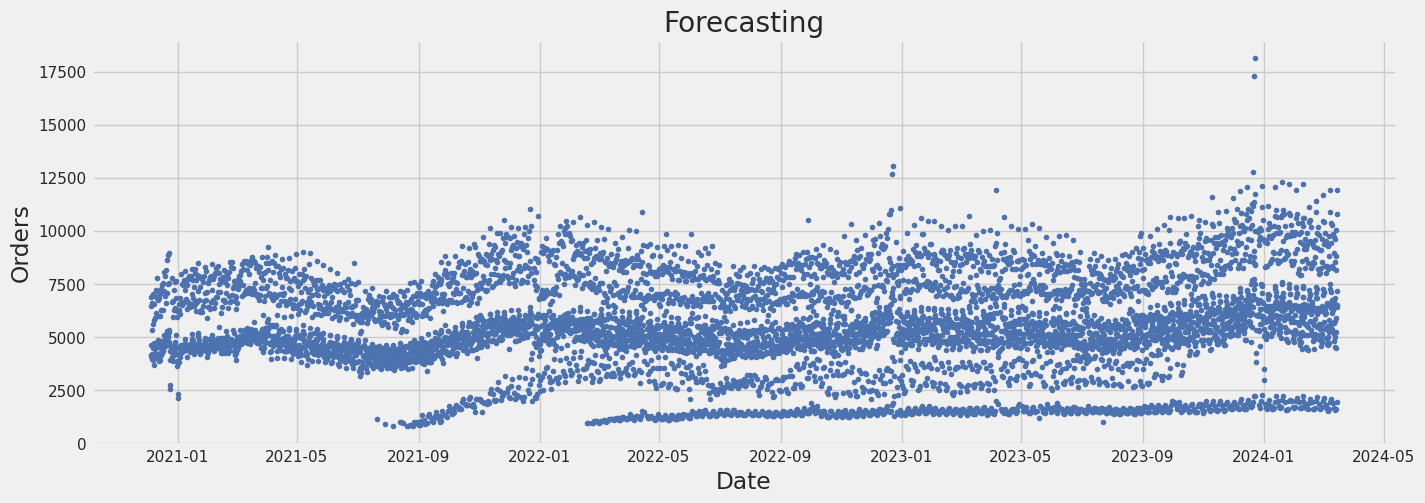

In [260]:
plt.figure(figsize=(15, 5))
plt.plot(train_preprocessed['date'], train_preprocessed['orders'], '.', color=color_pal[0])
plt.title('Forecasting')
plt.xlabel('Date')
plt.ylabel('Orders')
plt.show()

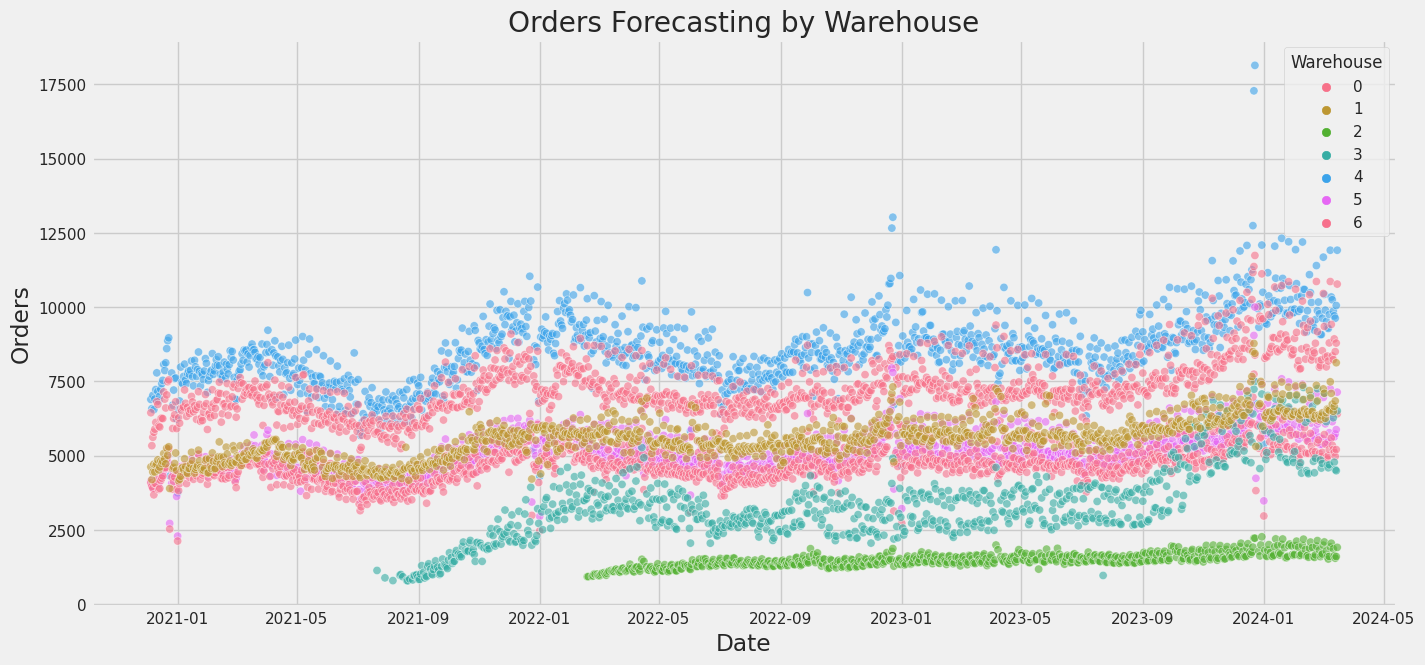

In [263]:
# Plot using seaborn
plt.figure(figsize=(15, 7))

sns.scatterplot(data=train_preprocessed, x='date', y='orders', hue='warehouse', palette='husl', alpha=0.6)

plt.title('Orders Forecasting by Warehouse')
plt.xlabel('Date')
plt.ylabel('Orders')
plt.legend(title='Warehouse')
plt.show()

## removing outliers

In [266]:
def remove_outliers_zscore(df, group_col, value_col, threshold=3):
    # Group by the warehouse
    grouped = df.groupby(group_col)
    
    # Initialize an empty DataFrame for filtered data
    filtered_df = pd.DataFrame()

    for name, group in grouped:
        # Calculate Z-scores for the group
        z_scores = np.abs(stats.zscore(group[value_col]))
        
        # Filter out outliers
        group_filtered = group[z_scores < threshold]
        
        # Append to the filtered DataFrame
        filtered_df = pd.concat([filtered_df, group_filtered], ignore_index=True)
    
    return filtered_df

# Apply the function
train_filtered_zscore = remove_outliers_zscore(train_preprocessed, 'warehouse', 'orders')

def remove_outliers_iqr(df, group_col, value_col):
    # Group by the warehouse
    grouped = df.groupby(group_col)
    
    # Initialize an empty DataFrame for filtered data
    filtered_df = pd.DataFrame()

    for name, group in grouped:
        # Calculate Q1 and Q3
        Q1 = group[value_col].quantile(0.25)
        Q3 = group[value_col].quantile(0.75)
        IQR = Q3 - Q1
        
        # Define outlier bounds
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Filter out outliers
        group_filtered = group[(group[value_col] >= lower_bound) & (group[value_col] <= upper_bound)]
        
        # Append to the filtered DataFrame
        filtered_df = pd.concat([filtered_df, group_filtered], ignore_index=True)
    
    return filtered_df

# Apply the function
train_filtered_iqr = remove_outliers_iqr(train_filtered_zscore, 'warehouse', 'orders')


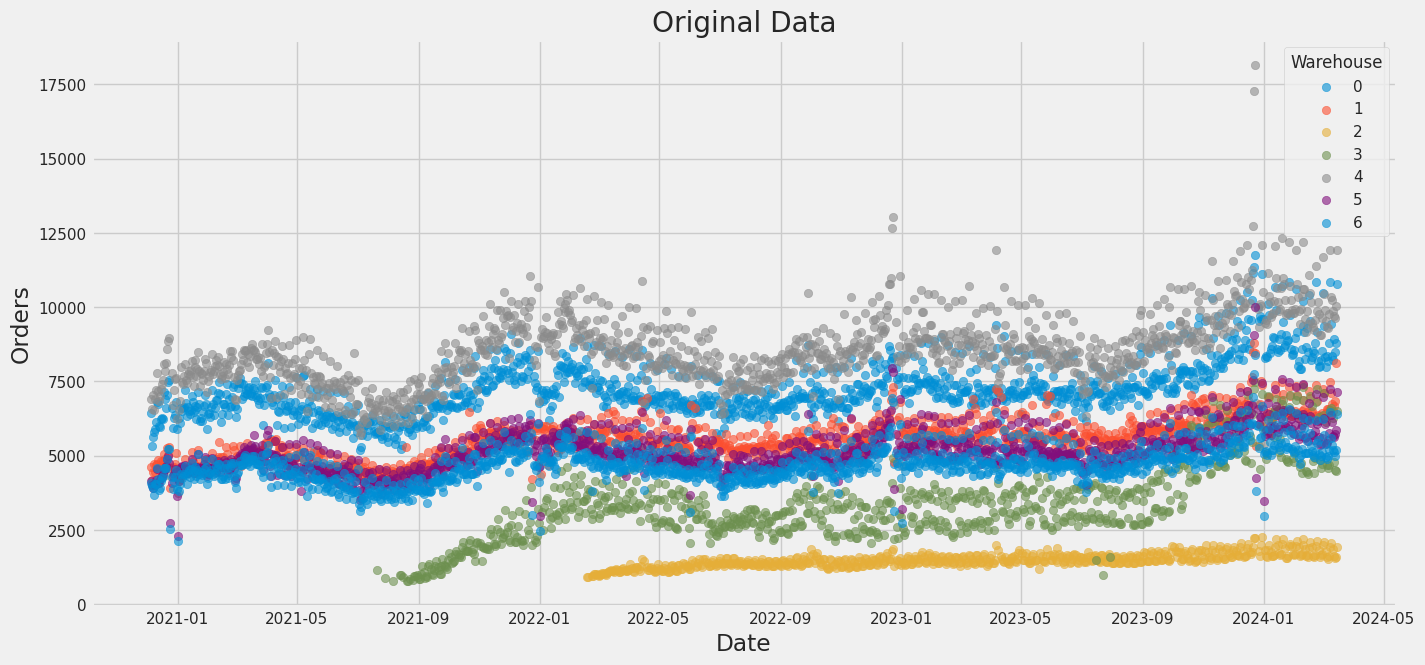

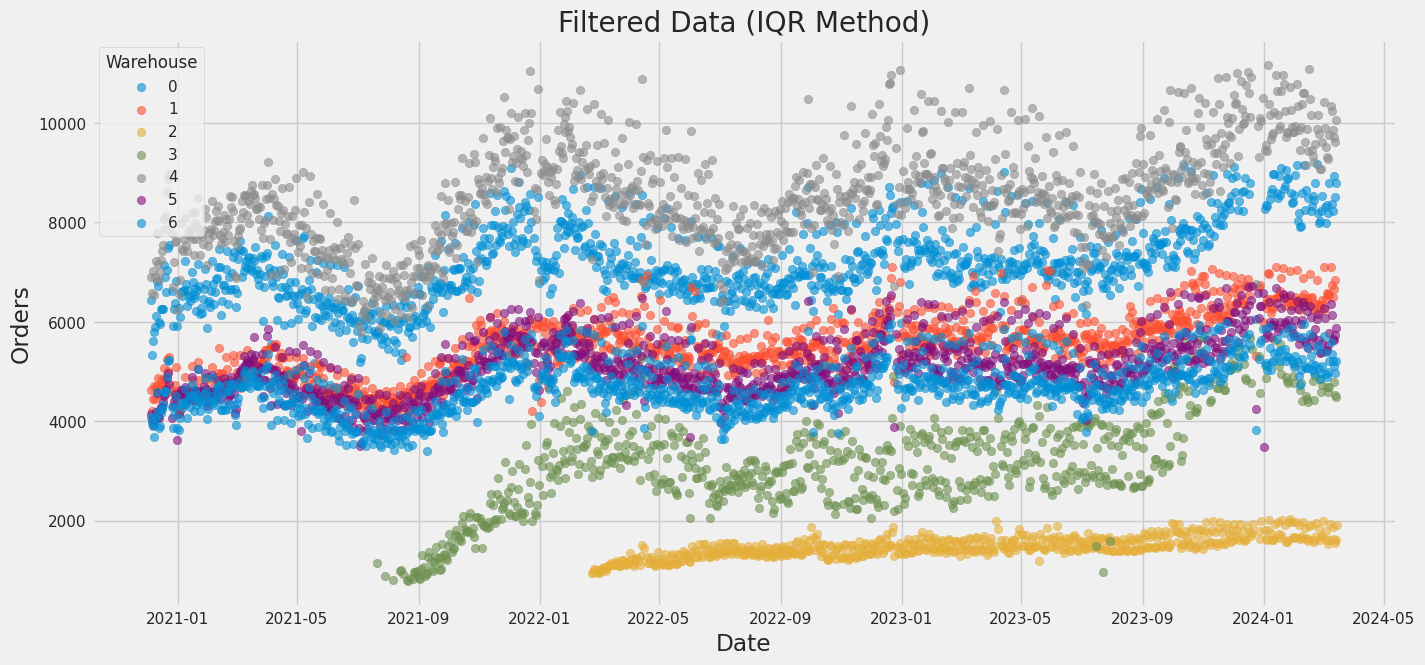

In [267]:
def plot_data(df, group_col, value_col, title):
    plt.figure(figsize=(15, 7))
    for name, group in df.groupby(group_col):
        plt.scatter(group['date'], group[value_col], label=name, alpha=0.6)
    
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Orders')
    plt.legend(title='Warehouse')
    plt.show()

# Plot before filtering
plot_data(train_preprocessed, 'warehouse', 'orders', 'Original Data')

# Plot after filtering
plot_data(train_filtered_iqr, 'warehouse', 'orders', 'Filtered Data (IQR Method)')

In [268]:
# Separate features and target in train data
X = train_filtered_iqr.drop(columns=['orders', 'id', 'date'], axis=1)
y = train_filtered_iqr['orders']

# Scale the features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Prepare test data for submission
test_ids = test_preprocessed['id']
test = test_preprocessed.drop(columns=['id', 'date'], axis=1)
test = scaler.transform(test)

In [269]:
tscv = TimeSeriesSplit(n_splits=5)
model = xgb.XGBRegressor(n_estimators=1000)

# Collect results
mape_scores = []

for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Calculate MAPE
    mape = mean_absolute_percentage_error(y_test, y_pred)
    mape_scores.append(mape)
    print(f"Fold MAPE: {mape:0.3f}")

# Print average MAPE
average_mape = np.mean(mape_scores)
print(f"Average MAPE: {average_mape:0.3f}")

Fold MAPE: 0.372
Fold MAPE: 0.387
Fold MAPE: 0.688
Fold MAPE: 0.635
Fold MAPE: 0.090
Average MAPE: 0.434


In [271]:
submission_df = pd.DataFrame({'id':ids, 'orders': model.predict(test)})
submission_df.to_csv('submission.csv', index=False)